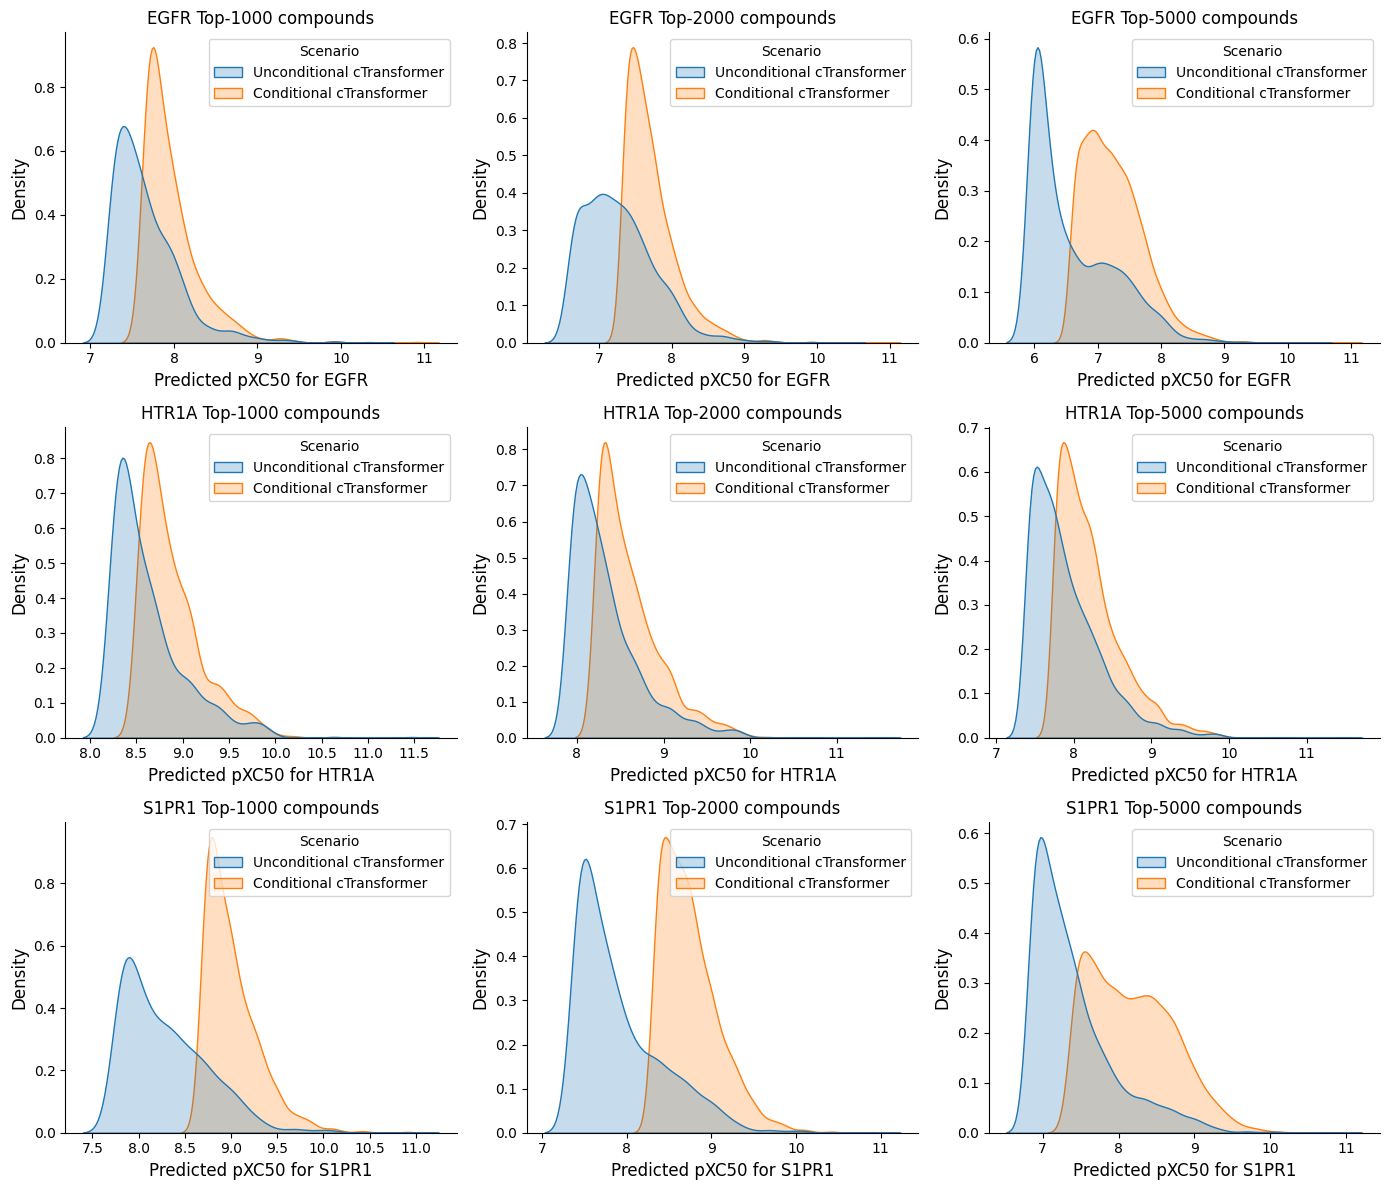

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pal=list(sns.color_palette("tab10"))

fig, axes = plt.subplots(3, 3, figsize=(14, 12))

names = [
    'EGFR',
    'HTR1A',
    'S1PR1'
]

num = [
    1000,
    2000,
    5000
]

for i, name in enumerate(names):
    for j, n in enumerate(num):
        # rnn = pd.DataFrame({'pred_pXC50':np.load('./npy/y/{}_RNN_Y.npy'.format(name))}).sort_values(by=['pred_pXC50'],ascending=False).head(n)
        # rnn['Model']='cRNN'

        unconditional = pd.DataFrame({
            'pred_pXC50': np.load('../generated_molecules/npy/{}_Unconditional_Y.npy'.format(name))
        }).sort_values(by=['pred_pXC50'],ascending=False).head(n)
        unconditional['Scenario']='Unconditional cTransformer'

        trans = pd.DataFrame(
            {'pred_pXC50':np.load('../generated_molecules/npy/{}_Conditional_Y.npy'.format(name))}
        ).sort_values(by=['pred_pXC50'],ascending=False).head(n)
        trans['Scenario']='Conditional cTransformer'

        df = pd.concat([unconditional, trans]).reset_index()
        sns.kdeplot(data=df, x="pred_pXC50", bw_adjust=1, hue='Scenario',ax=axes[i, j], fill=True)

        axes[i, j].set_title('{} Top-{} compounds'.format(name, n), fontsize=12)
        axes[i, j].spines['right'].set_visible(False)
        axes[i, j].spines['top'].set_visible(False)
        axes[i, j].set_ylabel("Density", fontsize=12)
        axes[i, j].set_xlabel(f"Predicted pXC50 for {name}", fontsize=12)


    plt.tight_layout()

plt.show()

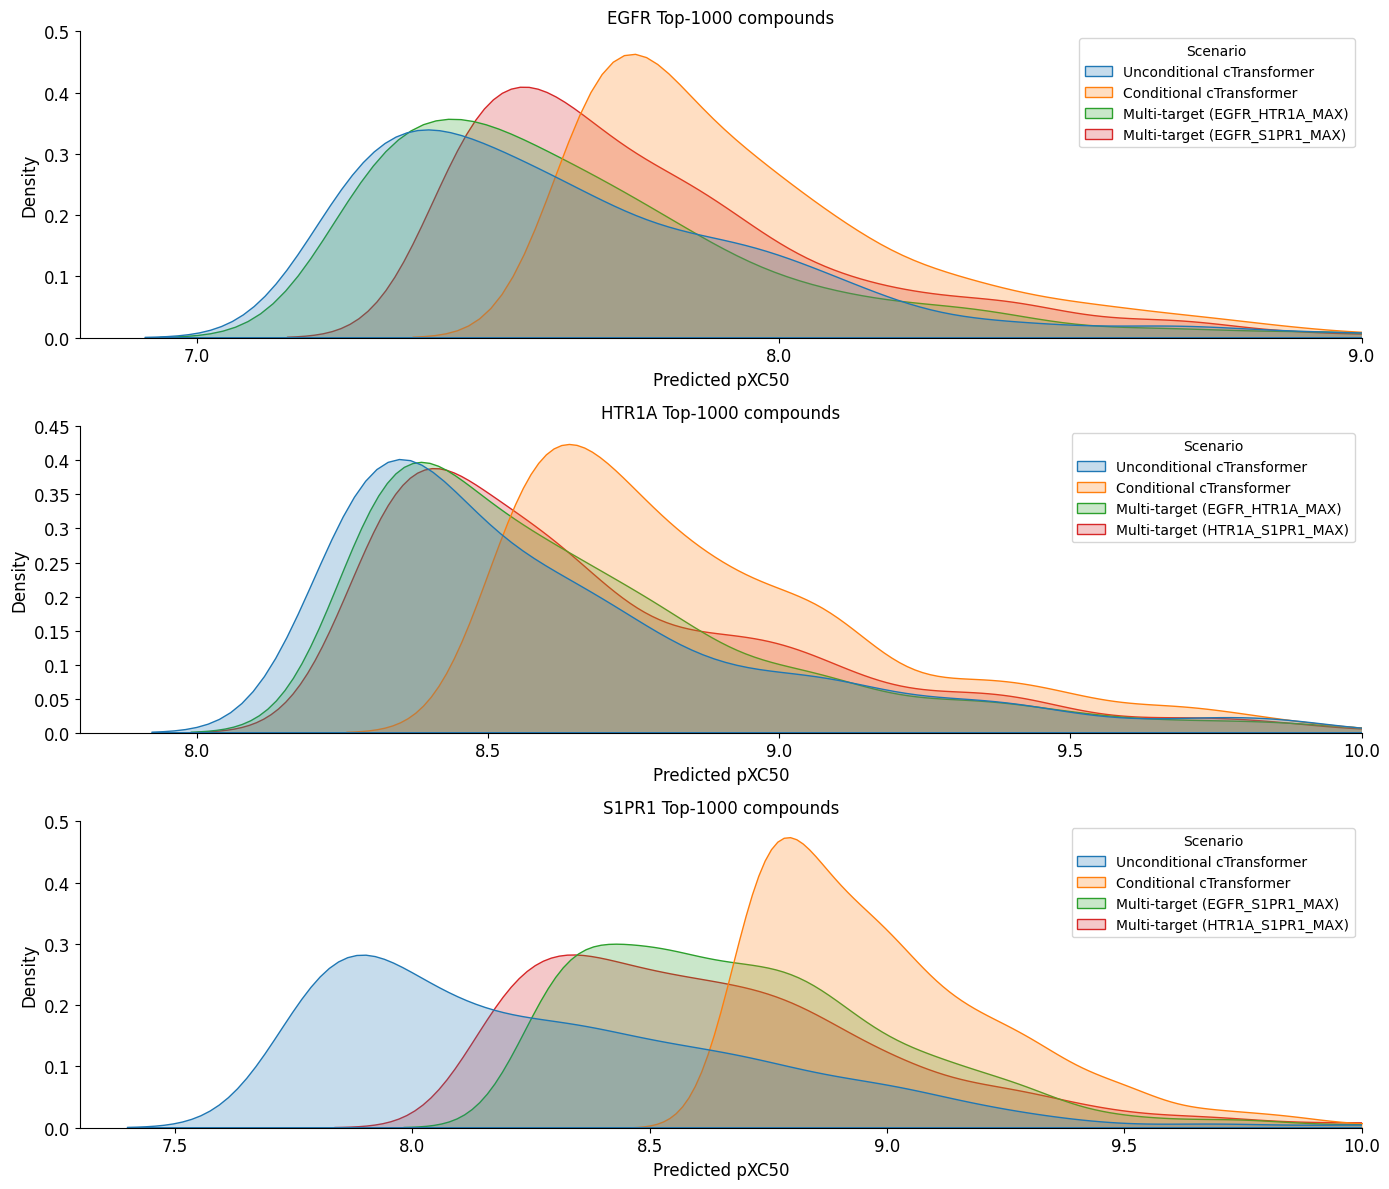

In [2]:
# Plot the multi-target distributions for the top 1000 compounds
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

agg = "MAX"

multi_targets = [
    f"EGFR_HTR1A_{agg}",
    f"EGFR_S1PR1_{agg}",
    f"HTR1A_S1PR1_{agg}"
]

n = 1000

names = [
    # 'Unconditional',
    ('EGFR', 6.8, 9),
    ('HTR1A', 7.8, 10),
    ('S1PR1', 7.3, 10)
]

for j, (name, min_x, max_x) in enumerate(names):
    df_list = []

    unconditional = pd.DataFrame({
        'pred_pXC50': np.load('../generated_molecules/npy/{}_Unconditional_Y.npy'.format(name))
    }).sort_values(by=['pred_pXC50'],ascending=False).head(n)
    unconditional['Scenario']='Unconditional cTransformer'
    df_list.append(unconditional)

    single_target = pd.DataFrame(
        {'pred_pXC50':np.load('../generated_molecules/npy/{}_Conditional_Y.npy'.format(name))}
    ).sort_values(by=['pred_pXC50'],ascending=False).head(n)
    single_target['Scenario']='Conditional cTransformer'
    df_list.append(single_target)

    for targets in multi_targets:
        if name in targets:
            multi_target = pd.DataFrame(
                {'pred_pXC50':np.load(f'../generated_molecules/npy/{targets}_Y_{name}.npy')}
            ).sort_values(by=['pred_pXC50'],ascending=False).head(n)
            multi_target['Scenario']=f'Multi-target ({targets})'
            df_list.append(multi_target)

    df = pd.concat(df_list).reset_index()

    sns.kdeplot(data=df, x="pred_pXC50", bw_adjust=1, hue='Scenario',ax=axes[j], fill=True)

    axes[j].set_title('{} Top-{} compounds'.format(name, n), fontsize=12)
    axes[j].spines['right'].set_visible(False)
    axes[j].spines['top'].set_visible(False)
    axes[j].set_ylabel("Density", fontsize=12)
    axes[j].set_xlabel("Predicted pXC50", fontsize=12)
    axes[j].yaxis.set_ticks(axes[j].get_yticks())
    axes[j].xaxis.set_ticks(axes[j].get_xticks())
    axes[j].set_yticklabels(axes[j].get_yticks().round(4), size=12)
    axes[j].set_xticklabels(axes[j].get_xticks().round(2), size=12)

    axes[j].set_xlim(min_x, max_x)


plt.tight_layout()
plt.show()

### Why does this approach seems to work for well for EGFR/S1PR1 target pair, but not for the pairs containing HTR1A?

In [3]:
import sys
import torch
from collections import namedtuple

sys.path.append('../')

from model_auto import Seq2SeqTransformer
from utils import read_delimited_file, read_csv_file
import vocabulary as mv

mol_list0_train = list(read_delimited_file('../train.smi'))
mol_list0_test = list(read_delimited_file('../test.smi'))

mol_list1, target_list = zip(*read_csv_file('../mol_target_dataloader/target.smi', num_fields=2))
mol_list = mol_list0_train
mol_list.extend(mol_list0_test) 
mol_list.extend(mol_list1)
vocabulary = mv.create_vocabulary(smiles_list=mol_list, tokenizer=mv.SMILESTokenizer())

BATCH_SIZE = 512
SRC_VOCAB_SIZE = len(vocabulary)
TGT_VOCAB_SIZE = len(vocabulary)

EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512

NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = DEVICE

args = namedtuple('args',['nhead'])(nhead=NHEAD)

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, 
                                EMB_SIZE, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE,
                                FFN_HID_DIM, args=args)
transformer = transformer.to(device)
transformer.load_state_dict(torch.load('../model_finetune.h5'))

<All keys matched successfully>

In [4]:
target_to_key = {
    "EGFR": torch.tensor([0]).to(device),
    "HTR1A": torch.tensor([1]).to(device),
    "S1PR1": torch.tensor([2]).to(device)
}

target_embedding = dict()

for target in target_to_key:
    embedding = transformer.emb(target_to_key[target])
    target_embedding[target] = embedding

target_embedding["EGFR"].shape

torch.Size([1, 512])

In [5]:
# compute the cosine similarity between the target embeddings
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

similarity = dict()

for target1 in target_embedding:
    for target2 in target_embedding:
        similarity[f"{target1}_{target2}"] = cos(target_embedding[target1], target_embedding[target2])

similarity

{'EGFR_EGFR': tensor([1.0000], device='cuda:0', grad_fn=<SumBackward1>),
 'EGFR_HTR1A': tensor([-0.0028], device='cuda:0', grad_fn=<SumBackward1>),
 'EGFR_S1PR1': tensor([-0.0558], device='cuda:0', grad_fn=<SumBackward1>),
 'HTR1A_EGFR': tensor([-0.0028], device='cuda:0', grad_fn=<SumBackward1>),
 'HTR1A_HTR1A': tensor([1.0000], device='cuda:0', grad_fn=<SumBackward1>),
 'HTR1A_S1PR1': tensor([-0.1698], device='cuda:0', grad_fn=<SumBackward1>),
 'S1PR1_EGFR': tensor([-0.0558], device='cuda:0', grad_fn=<SumBackward1>),
 'S1PR1_HTR1A': tensor([-0.1698], device='cuda:0', grad_fn=<SumBackward1>),
 'S1PR1_S1PR1': tensor([1.], device='cuda:0', grad_fn=<SumBackward1>)}

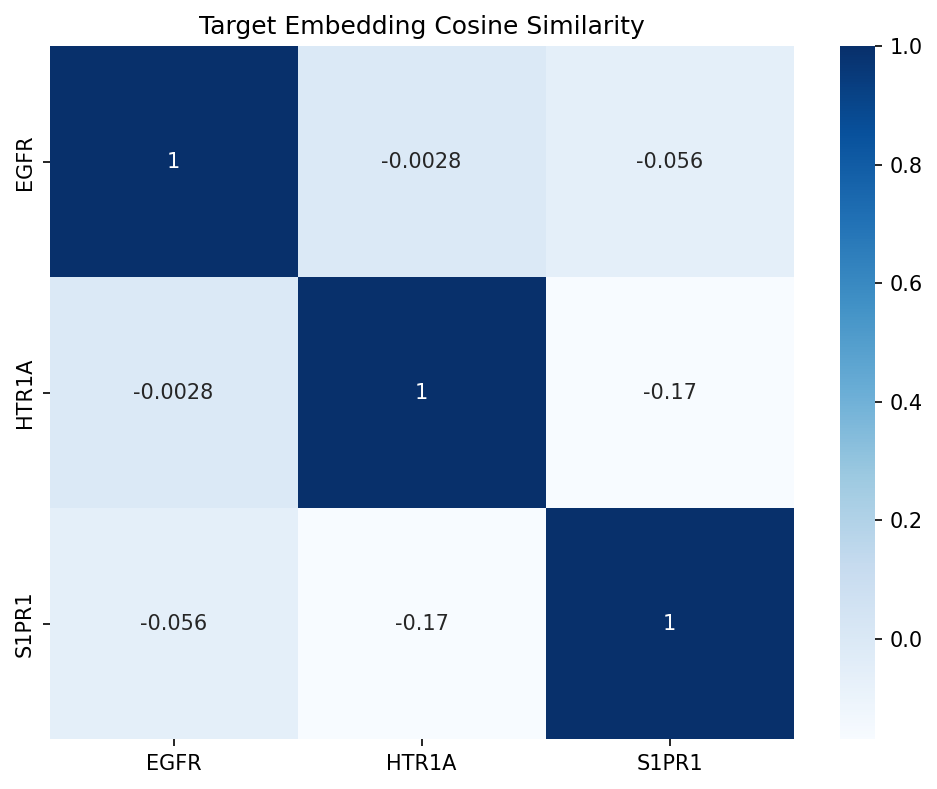

In [6]:
# plot the similarity matrix
import seaborn as sns

similarity_matrix = np.zeros((3, 3))

for i, target1 in enumerate(target_embedding):
    for j, target2 in enumerate(target_embedding):
        similarity_matrix[i, j] = similarity[f"{target1}_{target2}"].item()

plt.figure(figsize=(8, 6), dpi=150)

sns.heatmap(
    similarity_matrix, 
    annot=True, cmap='Blues',
    xticklabels=target_embedding.keys(), 
    yticklabels=target_embedding.keys()
)

plt.title('Target Embedding Cosine Similarity')

plt.show()

In [7]:
egfr_sequence = """MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEV
VLGNLEITYVQRNYDLSFLKTIQEVAGYVLIALNTVERIPLENLQIIRGNMYYENSYALA
VLSNYDANKTGLKELPMRNLQEILHGAVRFSNNPALCNVESIQWRDIVSSDFLSNMSMDF
QNHLGSCQKCDPSCPNGSCWGAGEENCQKLTKIICAQQCSGRCRGKSPSDCCHNQCAAGC
TGPRESDCLVCRKFRDEATCKDTCPPLMLYNPTTYQMDVNPEGKYSFGATCVKKCPRNYV
VTDHGSCVRACGADSYEMEEDGVRKCKKCEGPCRKVCNGIGIGEFKDSLSINATNIKHFK
NCTSISGDLHILPVAFRGDSFTHTPPLDPQELDILKTVKEITGFLLIQAWPENRTDLHAF
ENLEIIRGRTKQHGQFSLAVVSLNITSLGLRSLKEISDGDVIISGNKNLCYANTINWKKL
FGTSGQKTKIISNRGENSCKATGQVCHALCSPEGCWGPEPRDCVSCRNVSRGRECVDKCN
LLEGEPREFVENSECIQCHPECLPQAMNITCTGRGPDNCIQCAHYIDGPHCVKTCPAGVM
GENNTLVWKYADAGHVCHLCHPNCTYGCTGPGLEGCPTNGPKIPSIATGMVGALLLLLVV
ALGIGLFMRRRHIVRKRTLRRLLQERELVEPLTPSGEAPNQALLRILKETEFKKIKVLGS
GAFGTVYKGLWIPEGEKVKIPVAIKELREATSPKANKEILDEAYVMASVDNPHVCRLLGI
CLTSTVQLITQLMPFGCLLDYVREHKDNIGSQYLLNWCVQIAKGMNYLEDRRLVHRDLAA
RNVLVKTPQHVKITDFGLAKLLGAEEKEYHAEGGKVPIKWMALESILHRIYTHQSDVWSY
GVTVWELMTFGSKPYDGIPASEISSILEKGERLPQPPICTIDVYMIMVKCWMIDADSRPK
FRELIIEFSKMARDPQRYLVIQGDERMHLPSPTDSNFYRALMDEEDMDDVVDADEYLIPQ
QGFFSSPSTSRTPLLSSLSATSNNSTVACIDRNGLQSCPIKEDSFLQRYSSDPTGALTED
SIDDTFLPVPEYINQSVPKRPAGSVQNPVYHNQPLNPAPSRDPHYQDPHSTAVGNPEYLN
TVQPTCVNSTFDSPAHWAQKGSHQISLDNPDYQQDFFPKEAKPNGIFKGSTAENAEYLRV
APQSSEFIGA"""

htr1a_sequence = """MDVLSPGQGNNTTSPPAPFETGGNTTGISDVTVSYQVITSLLLGTLIFCAVLGNACVVAA
IALERSLQNVANYLIGSLAVTDLMVSVLVLPMAALYQVLNKWTLGQVTCDLFIALDVLCC
TSSILHLCAIALDRYWAITDPIDYVNKRTPRRAAALISLTWLIGFLISIPPMLGWRTPED
RSDPDACTISKDHGYTIYSTFGAFYIPLLLMLVLYGRIFRAARFRIRKTVKKVEKTGADT
RHGASPAPQPKKSVNGESGSRNWRLGVESKAGGALCANGAVRQGDDGAALEVIEVHRVGN
SKEHLPLPSEAGPTPCAPASFERKNERNAEAKRKMALARERKTVKTLGIIMGTFILCWLP
FFIVALVLPFCESSCHMPTLLGAIINWLGYSNSLLNPVIYAYFNKDFQNAFKKIIKCKFC
RQ"""

s1pr1_sequence = """MGPTSVPLVKAHRSSVSDYVNYDIIVRHYNYTGKLNISADKENSIKLTSVVFILICCFII
LENIFVLLTIWKTKKFHRPMYYFIGNLALSDLLAGVAYTANLLLSGATTYKLTPAQWFLR
EGSMFVALSASVFSLLAIAIERYITMLKMKLHNGSNNFRLFLLISACWVISLILGGLPIM
GWNCISALSSCSTVLPLYHKHYILFCTTVFTLLLLSIVILYCRIYSLVRTRSRRLTFRKN
ISKASRSSEKSLALLKTVIIVLSVFIACWAPLFILLLLDVGCKVKTCDILFRAEYFLVLA
VLNSGTNPIIYTLTNKEMRRAFIRIMSCCKCPSGDSAGKFKRPIIAGMEFSRSKSDNSSH
PQKDEGDNPETIMSSGNVNSSS"""

In [8]:
!pip install biopython

In [9]:
from Bio.Seq import Seq
from Bio.Align import PairwiseAligner

egfr_seq = Seq(egfr_sequence.replace('\n', ''))
htr1a_seq = Seq(htr1a_sequence.replace('\n', ''))
s1pr1_seq = Seq(s1pr1_sequence.replace('\n', ''))

targets_seq = {
    "EGFR": egfr_seq,
    "HTR1A": htr1a_seq,
    "S1PR1": s1pr1_seq
}

egfr_seq

Seq('MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFEDHFLSLQRM...IGA')

Alignment between EGFR and EGFR
Similarity: 1.00
Alignment between EGFR and HTR1A
Similarity: 0.21
Alignment between EGFR and S1PR1
Similarity: 0.20
Alignment between HTR1A and EGFR
Similarity: 0.59
Alignment between HTR1A and HTR1A
Similarity: 1.00
Alignment between HTR1A and S1PR1
Similarity: 0.35
Alignment between S1PR1 and EGFR
Similarity: 0.63
Alignment between S1PR1 and HTR1A
Similarity: 0.39
Alignment between S1PR1 and S1PR1
Similarity: 1.00


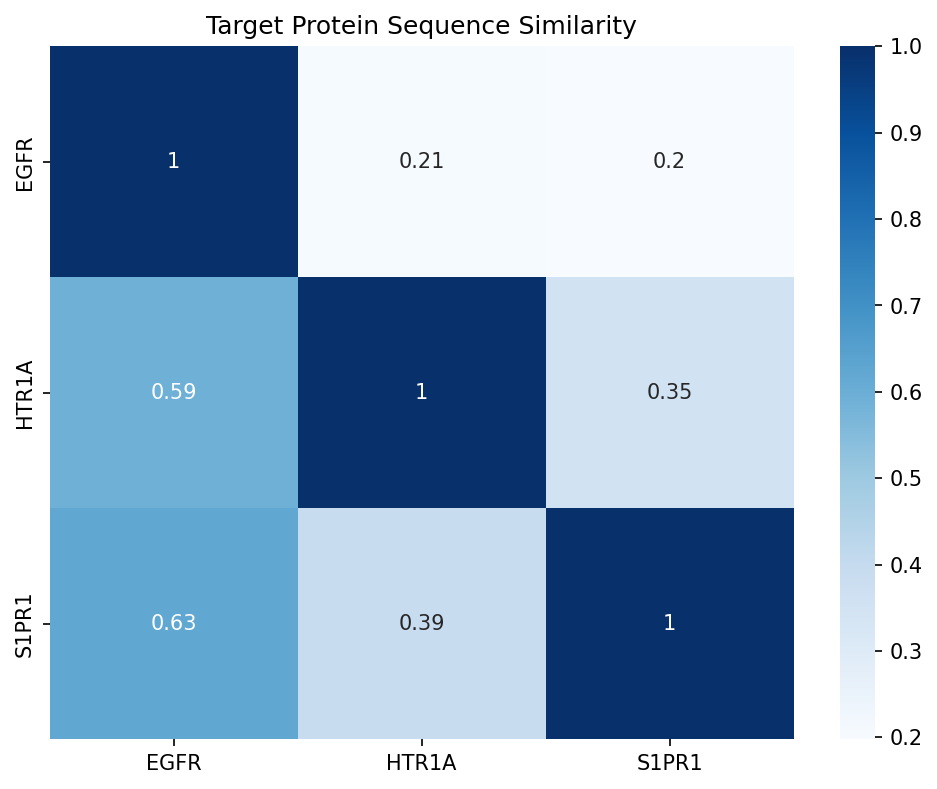

In [10]:
aligner = PairwiseAligner()

for target1 in targets_seq:
    for target2 in targets_seq:
        alignments = aligner.align(targets_seq[target1], targets_seq[target2])
        best_alignment = alignments[0]

        print(f"Alignment between {target1} and {target2}")
        # print(best_alignment)

        # Calculate sequence similarity as the fraction of identical residues
        similarity = best_alignment.score / len(targets_seq[target1])

        print(f"Similarity: {similarity:.2f}")

# plot the similarity matrix
similarity_matrix = np.zeros((3, 3))

for i, target1 in enumerate(targets_seq):
    for j, target2 in enumerate(targets_seq):
        alignments = aligner.align(targets_seq[target1], targets_seq[target2])
        best_alignment = alignments[0]

        similarity_matrix[i, j] = best_alignment.score / len(targets_seq[target1])

plt.figure(figsize=(8, 6), dpi=150)

sns.heatmap(
    similarity_matrix, 
    annot=True, cmap='Blues',
    xticklabels=targets_seq.keys(), 
    yticklabels=targets_seq.keys()
)

plt.title('Target Protein Sequence Similarity')

plt.show()

error1
error1
error1
error1
error1
error1
(5181, 2533) (5181,)
(6332, 2533) (6332,)
(1400, 2533) (1400,)


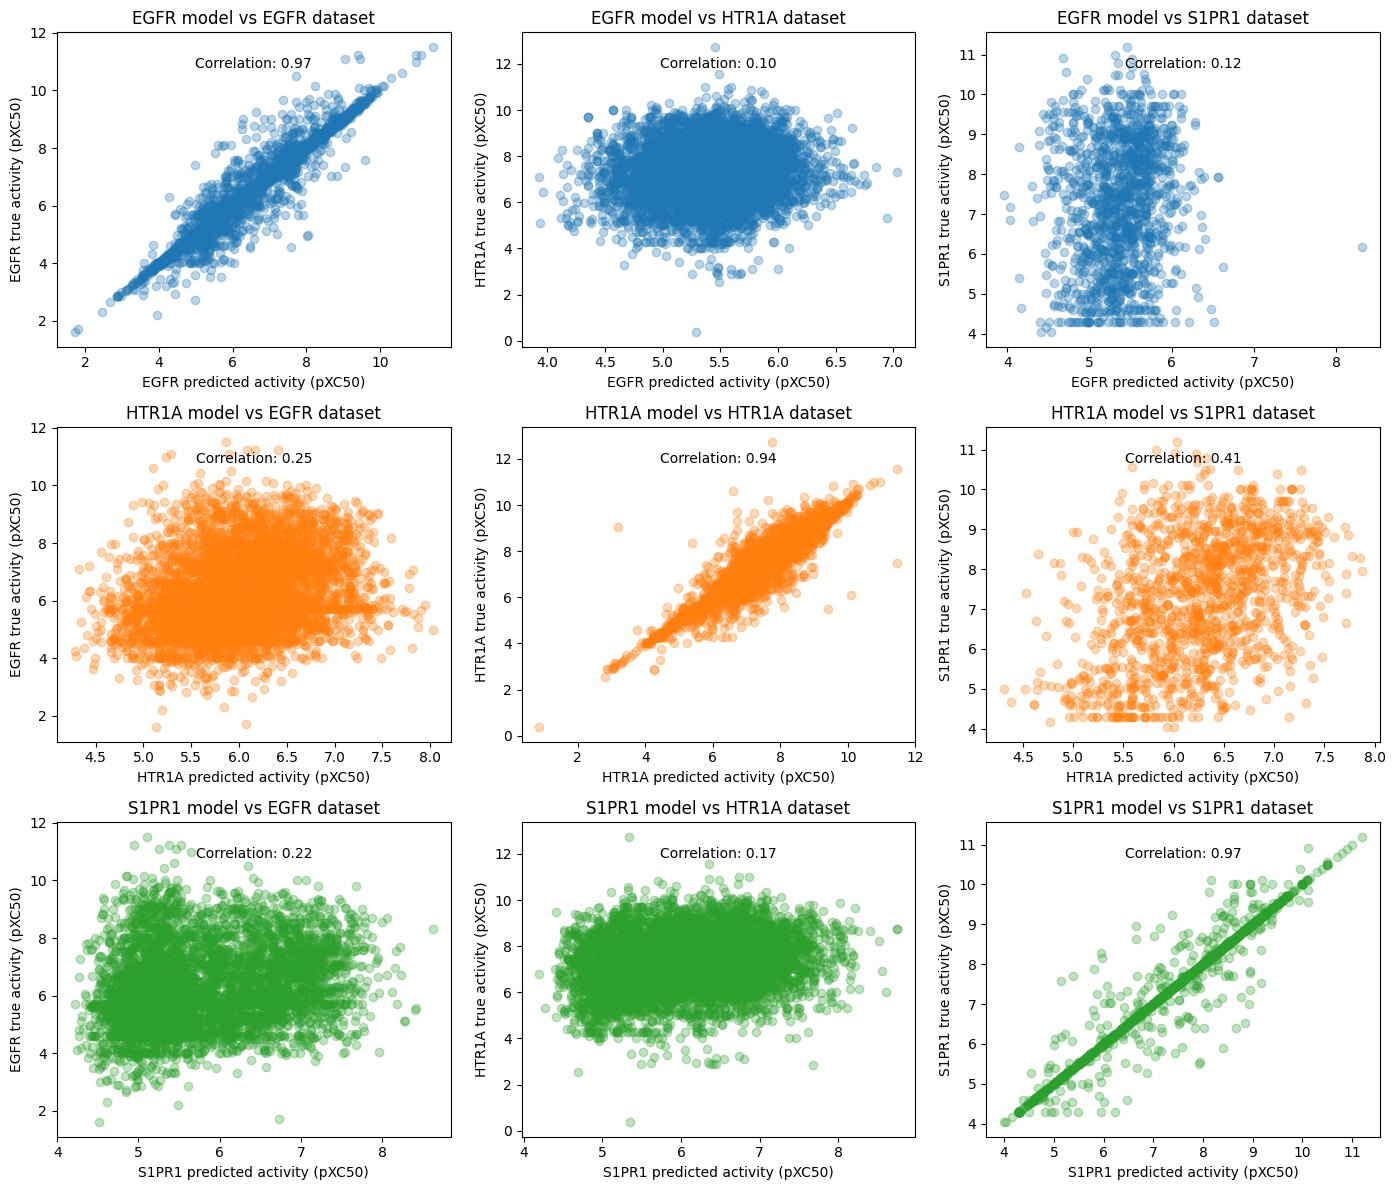

In [11]:
from rdkit import RDLogger

RDLogger.DisableLog('rdApp.*')

import lightgbm as lgb
from process_training_data import get_fp

# load qsar models for each target
targets = ["EGFR", "HTR1A", "S1PR1"]

model = dict()

for target in targets:
    model[target] = lgb.Booster(model_file=f'./model/{target}.txt')

# load active molecules dataset for each target
active_molecules = dict()

for target in targets:
    X = np.load('npy/{}_X.npy'.format(target))
    y = np.load('npy/{}_y.npy'.format(target))

    print(X.shape, y.shape)

    res = pd.DataFrame(X, columns=list(range(len(X[0]))))
    res['activity'] = y

    # res_active = res[res['activity'] >= 6.5]

    active_molecules[target] = res

# for each model, predict the activity of the active molecules datasets
predicted_activities = dict()

for target_model in targets:
    predicted_activities[target_model] = dict()

    for target_dataset in targets:
        X = active_molecules[target_dataset].drop(columns=['activity']).values
        y = active_molecules[target_dataset]['activity'].values

        predicted_activities[target_model][target_dataset] = model[target_model].predict(X)

# plot a scatter plot of the predicted activities for each target
# each row is a target model, each column is a target dataset
# the x axis is the predicted activity of the target model, the y axis is the predicted activity of the target dataset
fig, axes = plt.subplots(3, 3, figsize=(14, 12))

for i, target_model in enumerate(targets):
    for j, target_dataset in enumerate(targets):
        axes[i, j].scatter(
            predicted_activities[target_model][target_dataset], 
            active_molecules[target_dataset]['activity'], 
            # predicted_activities[target_dataset][target_dataset],
            alpha=0.3,
            color=pal[i]
        )

        axes[i, j].set_title(f'{target_model} model vs {target_dataset} dataset')
        axes[i, j].set_xlabel(f'{target_model} predicted activity (pXC50)')
        axes[i, j].set_ylabel(f'{target_dataset} true activity (pXC50)')

        # calculate the correlation coefficient
        correlation = np.corrcoef(
            predicted_activities[target_model][target_dataset], 
            active_molecules[target_dataset]['activity']
        )[0, 1]

        axes[i, j].text(0.5, 0.9, f'Correlation: {correlation:.2f}', 
                        horizontalalignment='center',
                        verticalalignment='center',
                        transform=axes[i, j].transAxes)


plt.tight_layout()
plt.show()

In [15]:
active_molecules_smiles = dict()

for target in targets:
    smiles_target = pd.read_csv(
        f'../generated_molecules/smiles/{target}.smi'
    ).head(100)

    active_molecules_smiles[target] = smiles_target

active_molecules_smiles

{'EGFR':                                                SMILES
 0   CCCOc1cc2ncc(C#N)c(Nc3ccc(OCc4ccccc4)c(Cl)c3)c...
 1   CC(C)=CC1C(C(=O)Nc2ccc(-c3cnc(C4CCCN4C(=O)CCc4...
 2   N#Cc1cnc2ccc(-c3cccc(C(=O)NC4CC4)c3)cc2c1NC1CC...
 3                    O=C(NCCc1ccccc1)NCc1ncc2ccccc2n1
 4   O=C(NCCCCN1CCCC1=O)Nc1cc2ncnc(Nc3ccc(OCc4ccccc...
 ..                                                ...
 95         COc1cccc(C(=O)COc2cccc(-c3ccc(CN)cc3)c2)c1
 96  C=S(O)(O)=CCNCc1ccn2ncnc(Nc3ccc4c(cnn4Cc4cccc(...
 97      N#Cc1ncn(CCCCN2CCN(c3cccc4[nH]ccc34)CC2)c1C#N
 98           CC(Sc1nnc2cc(-c3ccccc3)ncn12)C(=O)NC1CC1
 99                        c1cnc(NCc2ccc3c(c2)OCO3)nc1
 
 [100 rows x 1 columns],
 'HTR1A':                                            SMILES
 0           c1ccc2c(c1)CCC2Nc1ncnc2sc3c(c12)CCNC3
 1            N#Cc1ccc(N2CCN(C(CO)c3cccnc3)CC2)cc1
 2                   Brc1ccc(Oc2ccccc2C2CCNCC2)cc1
 3   Oc1c2c(c(O)n1CCCCN1CCN(c3ncccn3)CC1)C1C=CC2C1
 4    Cc1cc2ccccc2n1CCCCN1CCC(c2c[nH]c3nc

Text(0.5, 1.0, 'Tanimoto Similarity between Active Molecules Datasets')

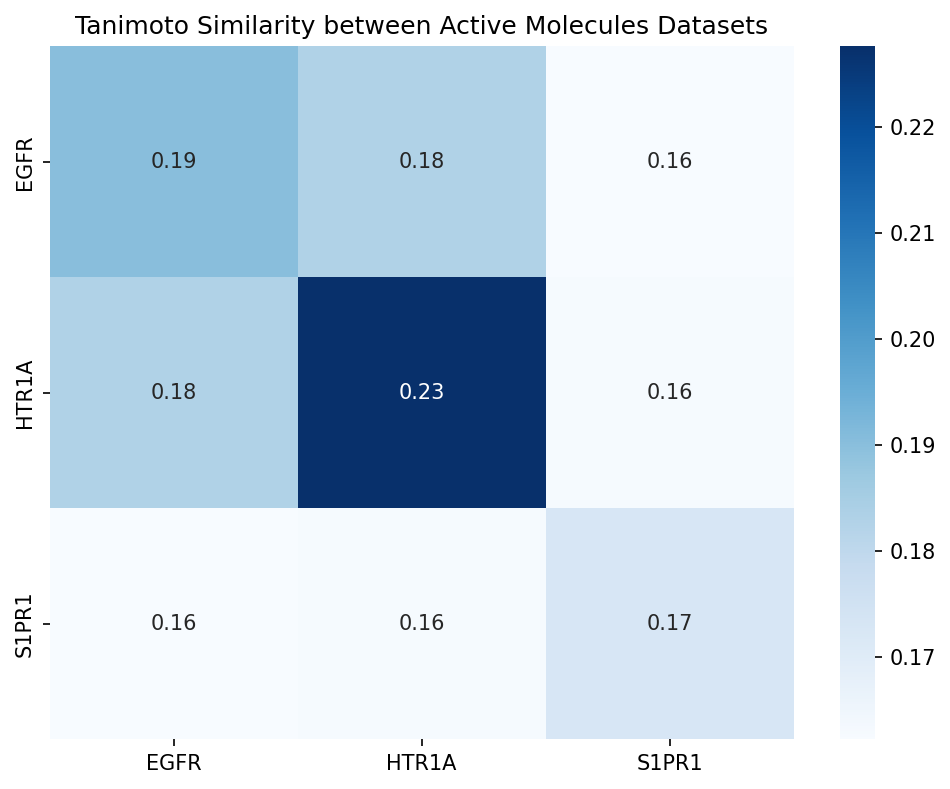

In [16]:
# import tanimoto bulk similarity
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import MolFromSmiles

# for each target, calculate the tanimoto similarity between the active molecules datasets
tanimoto_similarity = dict()

for target1 in targets:
    tanimoto_similarity[target1] = dict()

    for target2 in targets:
        tanimoto_similarity[target1][target2] = list()

        for smiles1 in active_molecules_smiles[target1]['SMILES']:
            mol1 = MolFromSmiles(smiles1)
            fp1 = AllChem.GetMorganFingerprint(mol1, 2)

            for smiles2 in active_molecules_smiles[target2]['SMILES']:
                mol2 = MolFromSmiles(smiles2)
                fp2 = AllChem.GetMorganFingerprint(mol2, 2)

                tanimoto_similarity[target1][target2].append(DataStructs.TanimotoSimilarity(fp1, fp2))

# plot the tanimoto similarity matrix
similarity_matrix = np.zeros((3, 3))

for i, target1 in enumerate(targets):
    for j, target2 in enumerate(targets):
        similarity_matrix[i, j] = np.mean(tanimoto_similarity[target1][target2])

plt.figure(figsize=(8, 6), dpi=150)

sns.heatmap(
    similarity_matrix, 
    annot=True, cmap='Blues',
    xticklabels=targets, 
    yticklabels=targets
)

plt.title('Tanimoto Similarity between Active Molecules Datasets')